In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2023, 1, 7)

In [3]:
DATA = '../data'

sp1950 = pd.read_csv(f'{DATA}/sp1950.csv')
nya1965 = pd.read_csv(f'{DATA}/nya1965.csv')
nasdaq1965 = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wilshire1990 = pd.read_csv(f'{DATA}/wilshire1990.csv')


nasdaq1965.tail()
states = pd.read_csv(f'{DATA}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2022-12-30,2022-12-30,3839.500000,0.997459,0.99995,15184.309570,0.996267,0.99989,10466.480469,0.998892,1.000428,38073.941406,0.997762,1.00028,1.000137,0
2023-01-03,2023-01-03,3824.139893,0.995999,0.99995,15154.450195,0.998034,0.99989,10386.980469,0.992404,1.000428,37900.250000,0.995438,1.00028,1.000137,0
2023-01-04,2023-01-04,3852.969971,1.007539,0.99995,15350.299805,1.012924,0.99989,10458.759766,1.006911,1.000428,38209.488281,1.008159,1.00028,1.000137,0
2023-01-05,2023-01-05,3808.100098,0.988354,0.99995,15225.400391,0.991863,0.99989,10305.240234,0.985321,1.000428,37782.898438,0.988835,1.00028,1.000137,0
2023-01-06,2023-01-06,3895.080078,1.022841,0.99995,15539.735352,1.020645,0.99989,10569.293945,1.025623,1.000428,38630.691406,1.022439,1.00028,1.000137,0


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ACN', 'ADBE', 'ADYEY', 'AMD', 'AMGN',
    'AMZN', 'ANET', 'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'CRWD',
    'DDOG', 'DGX', 'DIS', 'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY',
    'FLGT', 'FTNT', 'GH', 'GMED', 'GOOG', 'IDXX', 'INTG', 'ISRG',
    'JD', 'LRCX', 'LSPD', 'LULU', 'MA', 'MASI', 'MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NET', 'NOW', 'NVCR', 'NVDA', 'ODFL', 'OKTA',
    'OPEN', 'PAC', 'PANW', 'PAYC', 'PINS', 'PTON', 'PYPL', 'QDEL',
    'RBLX', 'RDFN', 'RGEN', 'RIVN', 'RMD', 'ROKU', 'RVLV', 'SAM',
    'SBUX', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC', 'TEAM', 'TMUS', 
    'TREX', 'TSCO', 'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR', 'TYL',
    'UPST', 'VEEV', 'VLD', 'VRTX', 'XPEV', 'ZEN', 'ZM']
LINGERERS = [
    'AMEH', 'AMRK', 'APT', 'BRTX', 'BTTR', 'BYRN', 'CENN',
    'CHEF', 'COOP', 'CTGO', 'CVE', 'DQ', 'DTST',
    'DYAI', 'EP', 'ERIE', 'ESOA', 'FCUV', 'FKWL', 'FSI', 'GGE', 'GME',
    'HBM', 'HMY', 'HNRG', 'IDR', 'INTZ',  'KREF', 'MCVT', 'MICS',
    'MNMD', 'MOBQ', 'OMQS', 'PACB', 'PETV', 'POWW', 'PRPH',
    'RVP', 'RVYL', 'SOBR', 'VIRT', 'WAVD', 'WKHS', 'YORW', 'ZEST',
    'ZYXI']
BEST_WEIGHTED = [
    'ABST', 'AGI', 'CEF', 'CGAU', 'CZFS', 'DGX', 'FNV', 'GCBC', 'IEI',
    'IIM', 'LFMD', 'MHN', 'MIN', 'MIY', 'MMU', 'MTA', 'NAZ', 'NEN',
    'NPV', 'NUO']

len(SYMBOLS + LINGERERS + BEST_WEIGHTED)

154

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2013, 1, 9), datetime.date(2023, 1, 7))

In [6]:
batch = sorted(list(set(SYMBOLS + LINGERERS + BEST_WEIGHTED)))

In [7]:
data = (
    yf
    .download(batch, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'})
    .sort_index())

[*********************100%***********************]  153 of 153 completed


In [8]:
data['state'] = states.state
data.tail()

AdjClose                                                        \
                  AAPL ABMD       ABNB   ABST         ACN        ADBE  ADYEY   
Date                                                                           
2022-12-30  129.929993  NaN  85.500000  10.44  266.839996  336.529999  13.80   
2023-01-03  125.070000  NaN  84.900002  10.75  270.260010  336.920013  13.80   
2023-01-04  126.360001  NaN  88.720001  11.08  269.339996  341.410004  14.01   
2023-01-05  125.019997  NaN  87.709999  11.65  262.980011  328.440002  13.50   
2023-01-06  129.619995  NaN  88.519997  11.11  269.209991  332.750000  13.91   

                                         ...   Volume                  \
              AGI        AMD       AMEH  ...     VRTX   WAVD     WKHS   
Date                                     ...                            
2022-12-30  10.11  64.769997  29.590000  ...  1030700  74600  4819600   
2023-01-03  10.36  64.019997  28.260000  ...  1100400  26200  4189300   
2023-01-04  10.85  64.660004  28.700001  ...  1137400  15000  2817300   
2023-01-05  10.78  62.330002  27.840000  ...  1187000   9600  2530600   
2023-01-06  10.86  63.959999  28.350000  ...   943342   8737  2338374   

                                                              state  
                  XPEV   YORW ZEN    ZEST         ZM     ZYXI        
Date                                                                 
2022-12-30  11666800.0  24600 NaN  136300  1864200.0   235600     0  
2023-01-03  27129700.0  32900 NaN   60000  2797600.0   182600     0  
2023-01-04  31419600.0  44700 NaN   27500  3209600.0    99800     0  
2023-01-05  21958400.0  35400 NaN   15800  2040100.0   122800     0  
2023-01-06  40690784.0  37618 NaN   68309  4042503.0  1141899     0  

[5 rows x 919 columns]

In [9]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [10]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

0

In [11]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = (
        sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0])
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [12]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [13]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [14]:
def get_hedged_sharpe(daily_returns, data):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return min(state_sharpe, lower_state_sharpe, upper_state_sharpe)

In [15]:
def get_weighted_sharpe(daily_returns, data, weights=[0.2, 0.6, 0.2]):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return (
        weights[0]*lower_state_sharpe
        + weights[1]*state_sharpe
        + weights[2]*upper_state_sharpe)

In [16]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [17]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [18]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [19]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [20]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [21]:
EXAMPLE = 'AAPL'

In [22]:
stock_data = get_stock_data(EXAMPLE, data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
(get_sharpe(daily_returns), 
 get_sharpe(daily_returns[data.state == CURRENT_STATE]))

(0.8687164011999591, -1.501150513250871)

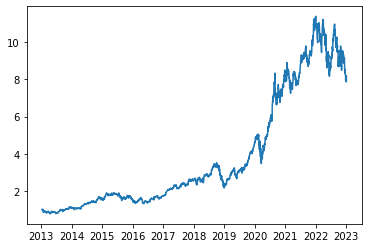

In [23]:
plt.plot(
    (get_daily_returns(data[('AdjClose', EXAMPLE)]) + 1).cumprod());

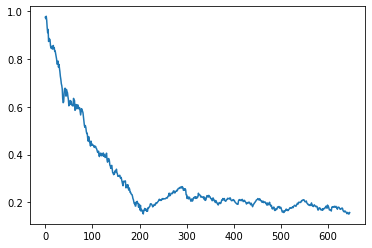

In [24]:
dr = get_daily_returns(
    data[('AdjClose', EXAMPLE)]
)[data.state == CURRENT_STATE]
dr = dr[dr.notnull()]
plt.plot((dr + 1).to_numpy().cumprod());

In [25]:
get_weighted_sharpe(daily_returns, data.copy())

-0.8738180922324316

In [26]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #hedged_sharpe = get_hedged_sharpe(daily_returns, data)
    weighted_sharpe = get_weighted_sharpe(daily_returns, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.AdjClose 
         + stock_data.High 
         + stock_data.Low 
         + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    n_notnull_resid = stock_data.resid.notnull().sum()
    stock_data['dev'] = np.nan
    stock_data.loc[stock_data.resid.notnull(), 'dev'] = (
        np.array(range(n_notnull_resid) / n_notnull_resid))
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.AdjClose, label='AdjClose')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],
        stock_data.rsi.tolist()[-1],
        stock_data.resid.tolist()[-1], 
        stock_data.dev.tolist()[-1],
        stock_data.drawdown.tolist()[-1],
        stock_data.pullup.tolist()[-1],
        sharpe,
        #state_sharpe,
        #hedged_sharpe,
        weighted_sharpe)

(0,
 0.1697962445065921,
 0.5943583631307111,
 0.5943583631307111,
 0.027162557459256165,
 0.05014625992478061,
 0.8687164011999591,
 -0.8738180922324316)

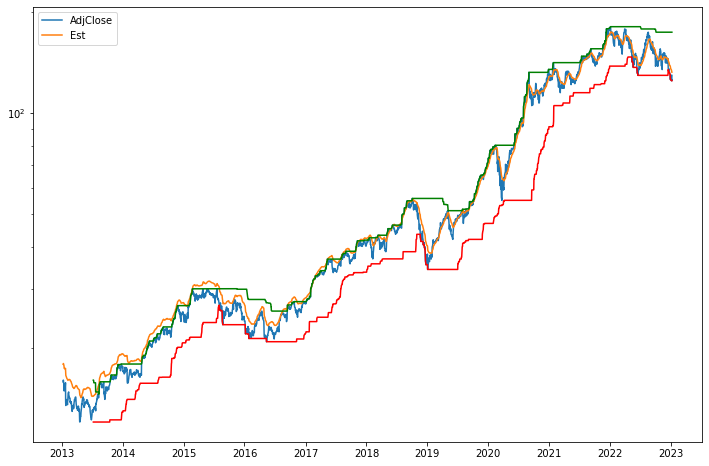

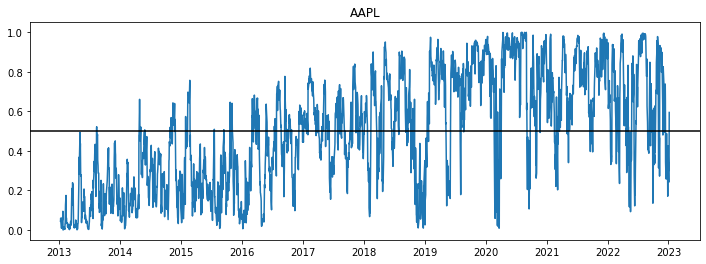

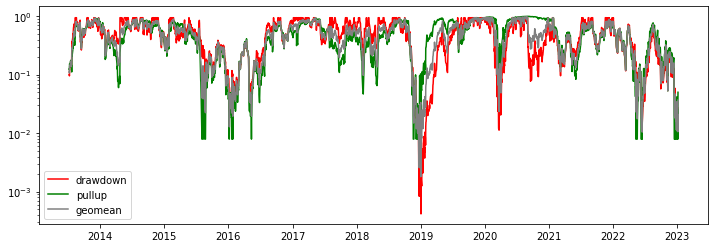

In [27]:
process_stock('AAPL', data.copy(), plot=True)

In [28]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    stock_stats = process_stock(stock, data)
    out.append([stock, *stock_stats])

AAPL... ABMD... ABNB... ABST... ACN... ADBE... ADYEY... AGI... AMD... AMEH... AMGN... AMRK... AMZN... ANET... APT... ASML... AXON... BROS... BRTX... BTTR... BYND... BYRN... CEF... CENN... CGAU... CHEF... CHWY... COOP... CRWD... CTGO... CVE... CZFS... DDOG... DGX... DIS... DOCS... DOCU... DQ... DTST... DUOL... DYAI... EDIT... EP... ERIE... ESOA... ETSY... FCUV... FKWL... FLGT... FNV... FSI... FTNT... GCBC... GGE... GH... GME... GMED... GOOG... HBM... HMY... HNRG... IDR... IDXX... IEI... IIM... INTG... INTZ... ISRG... JD... KREF... LFMD... LRCX... LSPD... LULU... MA... MASI... MCVT... MDB... MELI... MHN... MICS... MIN... MIY... MMU... MNMD... MNST... MOBQ... MSFT... MTA... MTCH... NAZ... NEN... NET... NOW... NPV... NUO... NVCR... NVDA... ODFL... OKTA... OMQS... OPEN... PAC... PACB... PANW... PAYC... PETV... PINS... POWW... PRPH... PTON... PYPL... QDEL... RBLX... RDFN... RGEN... RIVN... RMD... ROKU... RVLV... RVP... RVYL... SAM... SBUX... SE... SHOP... SNOW... SOBR... TASK... TDOC... TEAM

In [29]:
out_df = pd.DataFrame(
    data=out, 
    columns=[
        'stock', 'direction', 'RSI', 'fair_value_mult', 'dev_quantile',
        'drop','climb', 'sharpe', 'weighted_sharpe'])
out_df['geomean'] = np.sqrt(out_df['drop'] * out_df.climb)
out_df['score'] = (
    out_df.fair_value_mult
    * out_df.dev_quantile
    * out_df['drop']
    * out_df.climb) ** (1/4) 
out_df['RSIRev'] = 1 - out_df.RSI
out_df = out_df[
    ['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
     'dev_quantile', 'drop', 'climb', 'geomean', 'score',  'sharpe',
     'weighted_sharpe']]
out_df.RSI.fillna(out_df.RSI.median())
out_df.RSIRev.fillna(out_df.RSIRev.median())

out_df.weighted_sharpe.fillna(
    out_df.weighted_sharpe.mean(), inplace=True)
out_df.sort_values('stock')
out_df.head()

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,weighted_sharpe
0,AAPL,0,0.169796,0.830204,0.594358,0.594358,0.027163,0.050146,0.036907,0.148107,0.868716,-0.873818
1,ABMD,0,0.925689,0.074311,0.395511,0.397298,0.891768,0.758462,0.822418,0.570972,0.963560,-0.219779
2,ABNB,1,0.407480,0.592520,0.457854,0.457854,0.439698,0.183417,0.283986,0.360589,-0.127208,-0.986374
3,ABST,1,0.727127,0.272873,0.980135,0.980135,0.522775,0.804847,0.648655,0.797352,0.480716,0.347539
4,ACN,0,0.247703,0.752297,0.811283,0.811283,0.097785,0.213539,0.144503,0.342392,0.758683,-0.629593


In [30]:
out_df.geomean.quantile([0.05, 0.99])

0.05    0.032343
0.99    0.927204
Name: geomean, dtype: float64

In [31]:
out_df.to_csv('individ_quantiles.csv', index=False)

In [32]:
!open individ_quantiles.csv